# Kinase Coverage 

## Aim of this notebook

This notebook focuses on the coverage of our fragmentation libraries. We evaluate how many different kinases are represented in our fragmentation libraries and how many crystal ligands are represented by at least one fragment in KinFragLib compared to CustomKinFragLib. 

## Table of contents

1. Load fragment libraries 

2. Deduplicate library
3. Calculate kinase coverage
4. Calculate ligand coverage
    
    


## Imports and preprocessing

In [1]:
import pandas as pd

from pathlib import Path

import pandas as pd
import numpy as np

from rdkit import Chem
from kinfraglib import utils
from IPython.display import Image

from rdkit.Chem import MACCSkeys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
%load_ext autoreload
%autoreload 2

### Define global paths

In [3]:
HERE = Path(_dh[-1])
PATH_DATA = HERE / '../../data'

## 1. Load fragment library

In [4]:
# filter kinfraglib on stand. inchis
fragment_library = utils.read_fragment_library(PATH_DATA / "fragment_library")
fragment_library.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [5]:
fragment_library_custom = utils.read_fragment_library(PATH_DATA / "fragment_library_custom_filtered")
fragment_library_custom.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

## 2. Deduplicate library

Calculate standardized InChis for all fragments and deduplicate based on InChis

In [6]:
def standardized_inchi(mol):
    return Chem.inchi.MolToInchiKey(utils.standardize_mol(mol))

In [7]:
standardized_mol_inchis = {sp: list(sp_lib['ROMol'].apply(standardized_inchi)) for sp, sp_lib in fragment_library_custom.items()}

In [8]:
for sp, sp_lib in fragment_library.items():
    sp_lib['standard_inchi'] = sp_lib['ROMol'].apply(standardized_inchi)

In [9]:
filtered_fragment_lib = {sp: fragment_library[sp][fragment_library[sp]['standard_inchi'].isin(inchis)] 
                         for sp, inchis in standardized_mol_inchis.items()}
filtered_fragment_lib.keys()
# NBVAL_CHECK_OUTPUT

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2'])

## 3. Calculate kinase coverage

In [10]:
special_names = {"DCLK1": "DCAMKL1"}

In [11]:
def scale_size(n, min_n, max_n, min_size, max_size):
    """Min-max scaling of the numbers of kinase occurrences

    Args:
        n (int): number of occurrences 
        min_n (int): overall minimum    
        max_n (int): overall maximum
        min_size (int): scaled minimum
        max_size (int): scaled maximum

    Returns:
        _type_: _description_
    """
    r_size = max_size - min_size
    r_n = max_n - min_n
    s = (n - min_n)/r_n
    return int(r_size * s + min_size)

In [12]:
def kinase_map_from_df(sp_lib, color):
    """Define kinase map

    Args:
        sp_lib (pandas.DataFrame): subpocket dataframe
        color (str): rgb value for the subpocket

    Returns:
        pandas.DataFrame: subpocket dataframe with kinase coverage and color settings 
    """
    kinase_map = (sp_lib.groupby('kinase', as_index=False).size()
                    .rename(columns={'kinase': 'xName', 'size': 'num_fragments'}))

    kinase_map['xName'] = kinase_map['xName'].apply(lambda kinase : 
        special_names.get(kinase) or kinase.replace("-", "_"))

    kinase_map['shape'] = ['circle' for _ in range(len(kinase_map))]
    kinase_map['fill'] = [color for _ in range(len(kinase_map))]
    kinase_map['stroke'] = [color for _ in range(len(kinase_map))]
    kinase_map['strokeWidth'] = [color for _ in range(len(kinase_map))]
    kinase_map['fill'] = [color for _ in range(len(kinase_map))]
    
    return kinase_map

Calculate the kinase coverage per subpocket: 

In [13]:
print("Number of kinases represented: ")
print("Subpocket | KinFragLib  | CustomKinFragLib")
print("----------|-------------|-----------------")
kinases = []
custom_kinases = []
for sp, sp_lib_custom in filtered_fragment_lib.items():
    # extract kinases
    kinfraglib_kinases_df = kinase_map_from_df(fragment_library[sp], "rgb(240,128,128)")
    custom_kinases_df = kinase_map_from_df(sp_lib_custom, "rgb(0,128,0)")
    kinase_map = pd.concat([kinfraglib_kinases_df, custom_kinases_df])
    # print statistics
    print(f"{sp}        |\t{len(kinfraglib_kinases_df)}\t|\t{len(custom_kinases_df)}")
    kinases += list(kinfraglib_kinases_df.xName)
    custom_kinases += list(custom_kinases_df.xName)
    # point scaling 
    min_n, max_n = kinase_map['num_fragments'].min(), kinase_map['num_fragments'].max()
    kinase_map['size'] = kinase_map['num_fragments'].apply(lambda n: scale_size(n, min_n, max_n, 15, 50))
    # write to csv file 
    kinase_map.to_csv(sp + "_kinase_map.csv", doublequote=False)
# overall statistics 
print(f"Total     |\t{len(set(kinases))}\t|\t{len(set(custom_kinases))}")
# NBVAL_CHECK_OUTPUT

Number of kinases represented: 
Subpocket | KinFragLib  | CustomKinFragLib
----------|-------------|-----------------
AP        |	203	|	127
FP        |	183	|	113
SE        |	157	|	104
GA        |	154	|	98
B1        |	35	|	13
B2        |	30	|	17
Total     |	203	|	177


The csv file can be uploaded to [KinMap](http://www.kinhub.org/kinmap/) to create a kinase tree, where the kinases are colored red (KinFragLib) and green (CustomKinFragLib) if the kinase is represented in the respective fragment library. The size of the point is in proportion to the number of ligands present that are binding to the kinase. The example for the AP subpocket is shown below. 

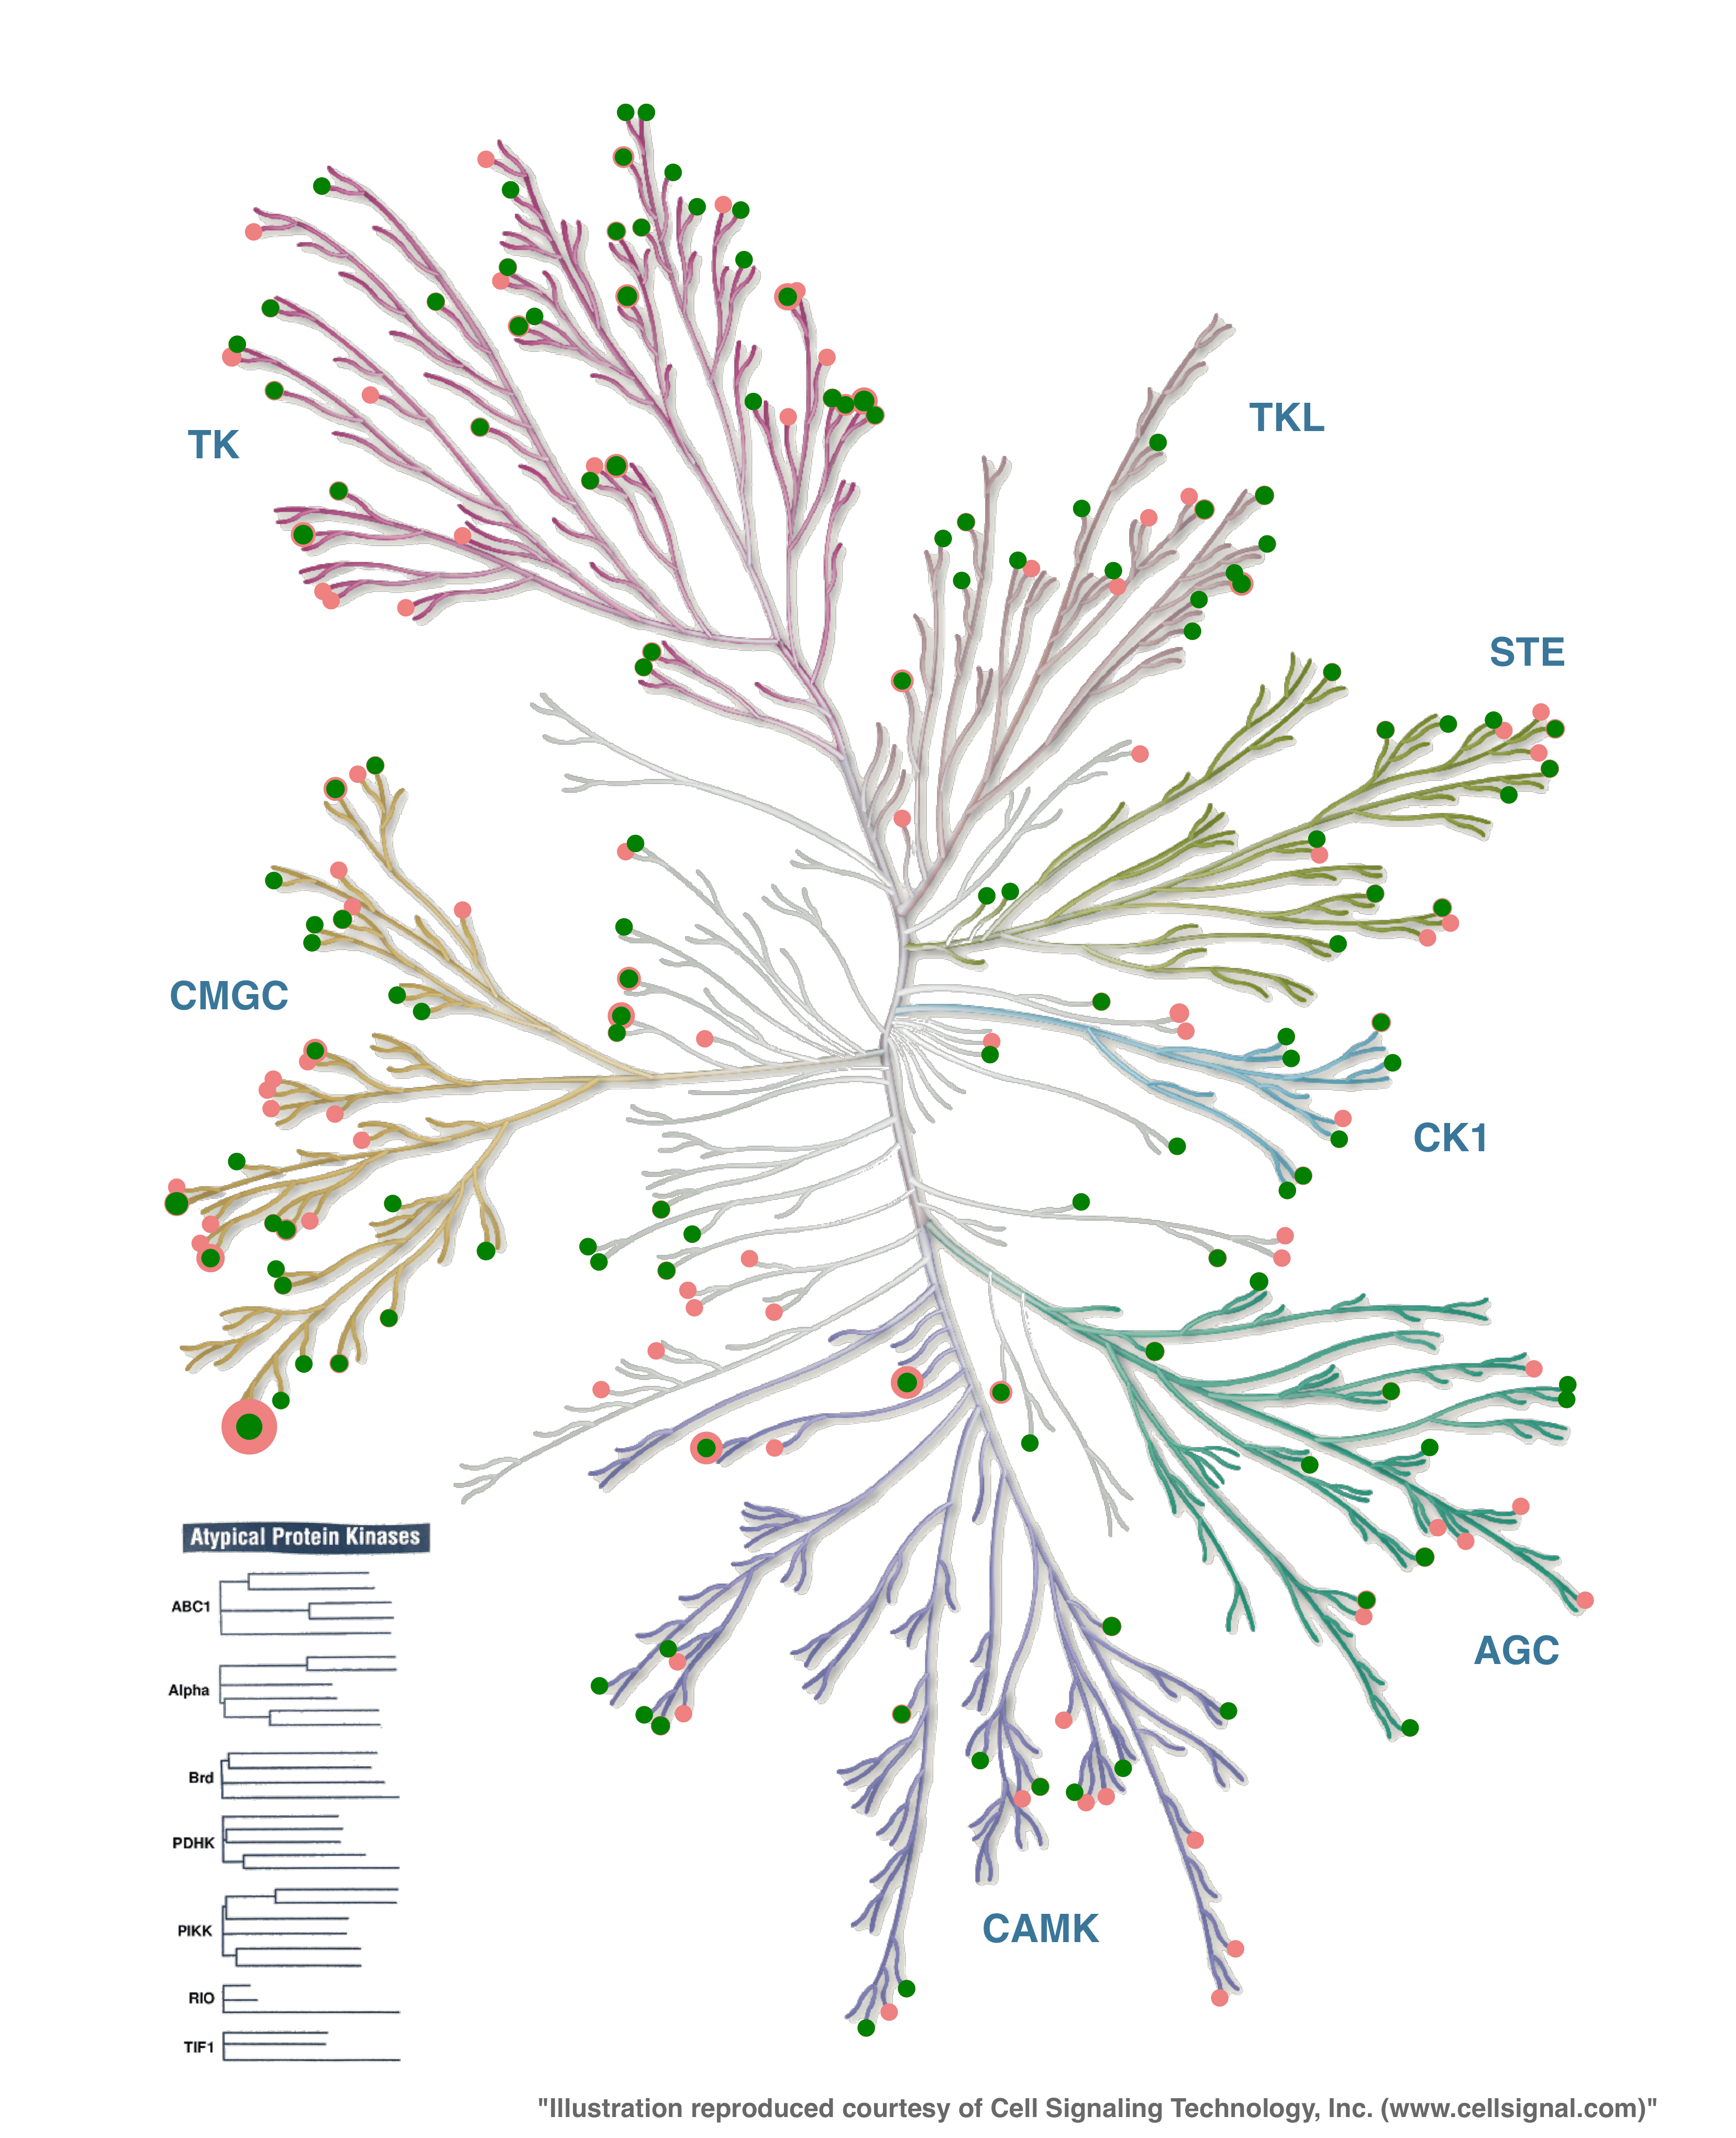

In [19]:
Image(filename='figures/kin_map_AP.png', width=500) 

## 4. Calculate ligand coverage

Get original ligands in KinFragLib and CustomKinFragLib (this might take a few minutes)

In [15]:
custom_original_ligands = utils.get_original_ligands(pd.concat(filtered_fragment_lib.values()))
len(custom_original_ligands)
# NBVAL_CHECK_OUTPUT

1870

In [16]:
kfl_original_ligands = utils.get_original_ligands(pd.concat(fragment_library.values()))
len(kfl_original_ligands)
# NBVAL_CHECK_OUTPUT

3231

Calculate the tSNE embeddings for KinFragLib and plot the difference between KinFragLib and CustomKinFragLib.

In [17]:
# code adapted from Notebook 2.3
def calc_tsne(original_maccs, custom_maccs): 
    """calculate tSNE embedding

    Args:
        original_maccs (pandas.Series): MACCS fingerprints to be embedded
        custom_maccs (pandas.Series): MACCS fingerprints from CustomKinFragLib

    Returns:
        pandas.DataFrame: tSNE coordinates for KinFragLib
        pandas.DataFrame: tSNE coordinates for CustomKinFragLib
    """
    # since custom is a subset of original, thus, we only need to fit on original
    # calculate MACCS fingerprints for t-sne 
    pca = PCA(n_components=50)
    crds = pca.fit_transform(list(original_maccs))
    crds_custom = pca.transform(list(custom_maccs))
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=0)
    crds_embedded = tsne.fit_transform(np.concatenate([crds, crds_custom], axis=0))

    return pd.DataFrame(crds_embedded[:len(original_maccs)], columns=["X", "Y"]), pd.DataFrame(crds_embedded[len(original_maccs):], columns=["X", "Y"])

We select all ligands where at least one fragment is present in KinFragLib. These ligands are plotted in a tSNE, and we color all CustomKinFragLib ligands in green to see the reduction of original ligands from KLIFS. 

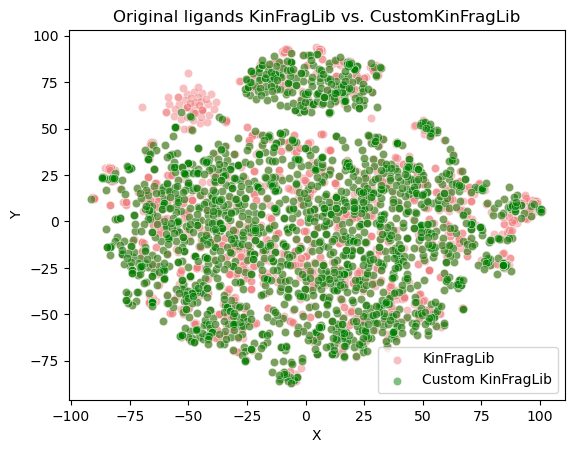

In [18]:
# also adapted from this notebook
kfl_tsne_df, custom_kfl_tsne_df = calc_tsne(kfl_original_ligands['ROMol'].apply(MACCSkeys.GenMACCSKeys), custom_original_ligands['ROMol'].apply(MACCSkeys.GenMACCSKeys))

sns.scatterplot(
    data=kfl_tsne_df,
    x="X",
    y="Y",
    color='lightcoral',
    alpha=0.5,
    label="KinFragLib"
).set_title("Original ligands KinFragLib vs. CustomKinFragLib")
sns.scatterplot(
    data=custom_kfl_tsne_df,
    x="X",
    y="Y",
    color='green',
    alpha=0.5,
    label="Custom KinFragLib"
)

plt.legend()
plt.savefig(f"figures/tsne_original_ligands.pdf", dpi=300, bbox_inches="tight")
plt.show()